# Credit Default Risk


In [1]:
%pip install vectice -U


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports


In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import vectice

connect = vectice.connect(api_token="your-api-key")
iteration = connect.phase("your-phase-id").create_iteration()

## Read in Data 

In [3]:
from sklearn.model_selection import train_test_split
# Training data
application_cleaned = pd.read_csv('./application_train.csv')
app_train_feat, app_test_feat = train_test_split(application_cleaned, test_size=0.15, random_state=42)
# Separate the target variable from the testing set
target_variable = 'TARGET'
app_test_feat_target = app_test_feat[target_variable]
app_test_feat = app_test_feat.drop(target_variable, axis=1)

# Print the shapes of the resulting dataframes
print('Training data shape: ', app_train_feat.shape)
print('Testing shape: ', app_test_feat.shape)
print('Testing target shape: ', app_test_feat_target.shape)


Training data shape:  (261384, 122)
Testing shape:  (46127, 121)
Testing target shape:  (46127,)


In [4]:
from vectice import FileResource, Dataset

In [5]:
data_origin = Dataset.origin(name = "Application train", resource = FileResource(paths='./application_train.csv', dataframes=application_cleaned))
iteration.log(data_origin)

File: ./application_train.csv wrapped successfully.
Code captured the following changed files; 23.4/samples/autolog/Kaggle_notebook.ipynb
Statistics are only captured for the first 100 columns of your dataframe.
New dataset: 'Application train' version: 'Version 1' added to iteration: 1.
Attachments: None
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739



# Exploratory Data Analysis

## Examine the Distribution of the Target Column

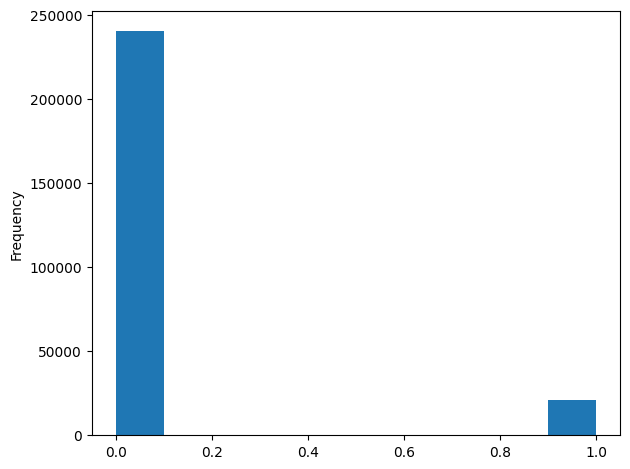

In [6]:
app_train_feat['TARGET'].astype(int).plot.hist()
plt.tight_layout()
plt.savefig("Target distribution.png")

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Encoding Categorical Variables

### Label Encoding and One-Hot Encoding

In [7]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train_feat:
    if app_train_feat[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_feat[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train_feat[col])
            # Transform both training and testing data
            app_train_feat[col] = le.transform(app_train_feat[col])
            app_test_feat[col] = le.transform(app_test_feat[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [8]:
# one-hot encoding of categorical variables
app_train_feat = pd.get_dummies(app_train_feat)
app_test_feat = pd.get_dummies(app_test_feat)
train_labels = app_train_feat['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train_feat, app_test_feat = app_train_feat.align(app_test_feat, join = 'inner', axis = 1)

# Add the target back in
app_train_feat['TARGET'] = train_labels


# Create an anomalous flag column
app_train_feat['DAYS_EMPLOYED_ANOM'] = app_train_feat["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train_feat['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


app_test_feat['DAYS_EMPLOYED_ANOM'] = app_test_feat["DAYS_EMPLOYED"] == 365243
app_test_feat["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
print('Training Features shape: ', app_train_feat.shape)
print('Testing Features shape: ', app_test_feat.shape)
print('There are %d anomalies in the test data out of %d entries' % (app_test_feat["DAYS_EMPLOYED_ANOM"].sum(), len(app_test_feat)))

Training Features shape:  (261384, 244)
Testing Features shape:  (46127, 243)
There are 8287 anomalies in the test data out of 46127 entries


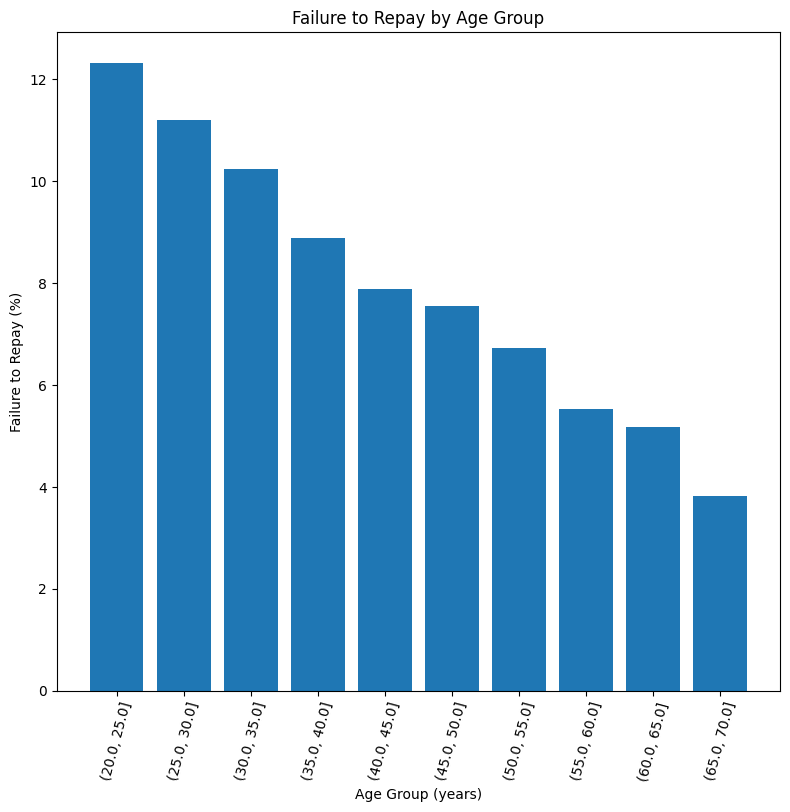

In [9]:
# Age information into a separate dataframe
app_train_feat['DAYS_BIRTH'] = abs(app_train_feat['DAYS_BIRTH'])
app_train_feat['YEARS_BIRTH'] = app_train_feat['DAYS_BIRTH'] / 365

# Bin the age data
app_train_feat['YEARS_BINNED'] = pd.cut(app_train_feat['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(app_train_feat.groupby('YEARS_BINNED').mean().index.astype(str), 100 * app_train_feat.groupby('YEARS_BINNED').mean()['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.tight_layout()
plt.savefig("Failure to repay by age group.png")

plt.title('Failure to Repay by Age Group')
app_train_feat = app_train_feat.drop(columns=['YEARS_BINNED', 'YEARS_BIRTH'])

Text(0.5, 1.0, 'Correlation Heatmap')

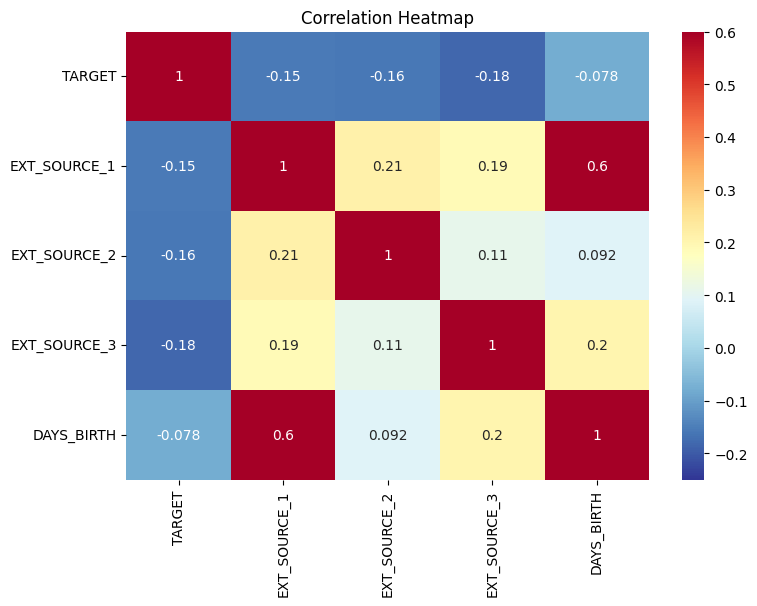

In [10]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(app_train_feat[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.tight_layout()
plt.savefig("Correlation.png")

plt.title('Correlation Heatmap')

In [11]:
def plot_feature_importances(features, feature_importance_values):
    
    df = pd.DataFrame({'feature': features, 'importance': feature_importance_values}).sort_values('importance', ascending = False).reset_index()
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); 
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig('Feature Importances.png')
    plt.show()

In [12]:
#app_train_feat.to_csv("./application_feat.csv",index=False)
clean_ds = Dataset.clean(name = "Application train feature", 
                         resource = FileResource(paths='./application_feat.csv', dataframes=app_train_feat), 
                         attachments=["Correlation.png","Target distribution.png","Failure to repay by age group.png" ], 
                         derived_from=data_origin)

iteration.log(clean_ds)

File: ./application_feat.csv wrapped successfully.
Statistics are only captured for the first 100 columns of your dataframe.
New dataset: 'Application train feature' version: 'Version 1' added to iteration: 1.
Attachments: Failure to repay by age group.png, Target distribution.png, Correlation.png
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739



In [13]:
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train_feat:
    train_no_missing = app_train_feat.drop(columns = ['TARGET'])

features = list(train_no_missing.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')
# Fit on the training data
imputer.fit(train_no_missing)

# Transform both training and testing data
train_no_missing = pd.DataFrame(imputer.transform(train_no_missing), columns=features).set_index('SK_ID_CURR')
test_no_missing = pd.DataFrame(imputer.transform(app_test_feat), columns=features).set_index('SK_ID_CURR')

In [14]:
#train_no_missing.to_csv("./training.csv",index=False)
#test_no_missing.to_csv("./testing.csv",index=False)

modeling_ds = Dataset.modeling(name = "Modeling",training_resource = FileResource(paths='./training.csv', dataframes=train_no_missing), 
                            testing_resource=FileResource(paths='./testing.csv', dataframes=test_no_missing),
                            derived_from=clean_ds)
iteration.log(modeling_ds)

File: ./training.csv wrapped successfully.
File: ./testing.csv wrapped successfully.
Statistics are only captured for the first 100 columns of your dataframe.
Statistics are only captured for the first 100 columns of your dataframe.
New dataset: 'Modeling' version: 'Version 1' added to iteration: 1.
Attachments: None
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739



# Modeling

ROC AUC Score: 0.7284616326891293
F1 Score: 0.26559118630729883
Recall Score: 0.5447941888619855


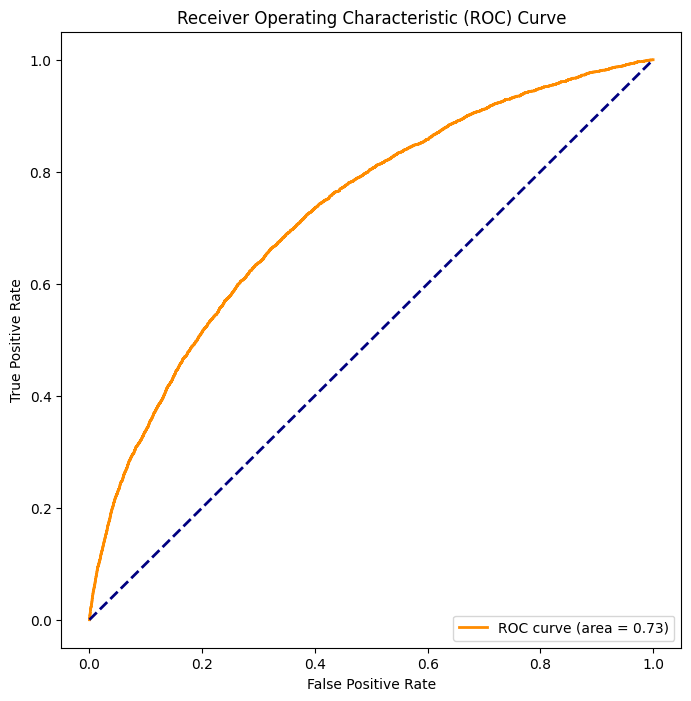

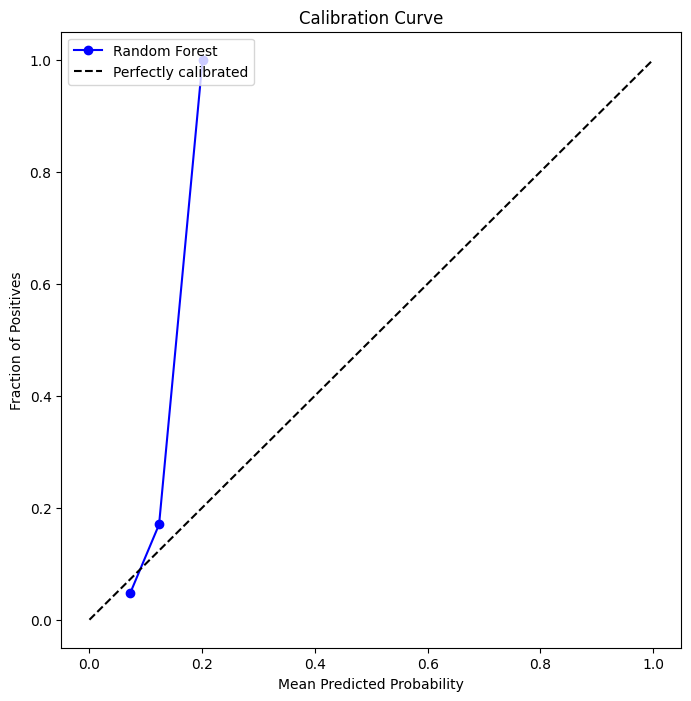

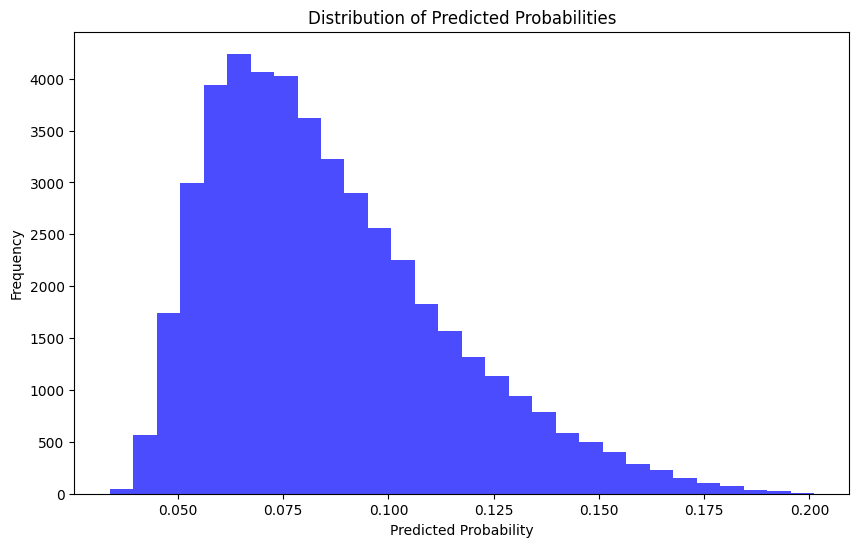

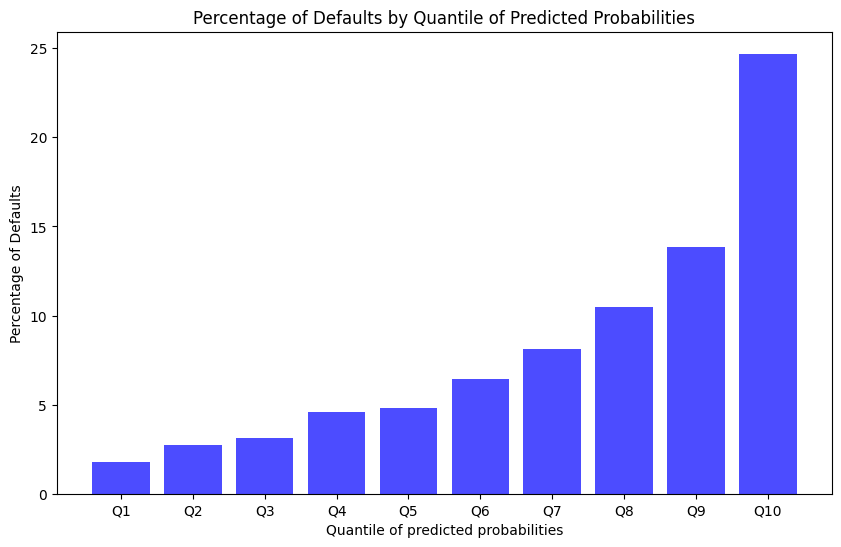

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, roc_curve, auc
from sklearn.calibration import calibration_curve


# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, min_samples_leaf=0.01, n_jobs = -1)
features = list(train_no_missing.columns)
# Train on the training data
random_forest.fit(train_no_missing, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_

# Make predictions on the test data
predictions = random_forest.predict_proba(test_no_missing)[:, 1]

roc_auc = roc_auc_score(app_test_feat_target.values, predictions)
# Sort instances based on predicted probabilities
sorted_indices = np.argsort(predictions)[::-1]
sorted_labels = app_test_feat_target.iloc[sorted_indices]

# Define the desired percentage (e.g., 25%)
desired_percentage = 0.25

# Identify the threshold probability corresponding to the desired percentage
threshold_index = int(desired_percentage * len(predictions))
threshold_probability = predictions[sorted_indices[threshold_index]]

# Apply the threshold to classify instances
binary_predictions = (predictions >= threshold_probability).astype(int)

# Calculate the recall at the desired percentage
recall = recall_score(app_test_feat_target.values, binary_predictions)
f1 = f1_score(app_test_feat_target.values,binary_predictions)

metric = {"auc": float(roc_auc),
          f"recall at {desired_percentage}%": float(recall),
          f"f1_score at {desired_percentage}%":float(f1)}

print("ROC AUC Score:", roc_auc)
print("F1 Score:", f1)
print("Recall Score:", recall)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(app_test_feat_target.values, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

# Plot calibration curve
prob_true, prob_pred = calibration_curve(app_test_feat_target.values, predictions, n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="upper left")
plt.savefig("calibration.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.savefig("Prediction_distribution.png")
plt.ylabel('Frequency')
plt.show()

# Create a DataFrame with predicted probabilities and true labels
df_results = pd.DataFrame({'Probability': predictions, 'Default': app_test_feat_target.values})

# Sort instances based on predicted probabilities
df_results = df_results.sort_values(by='Probability', ascending=False)

# Divide the sorted instances into quantiles (e.g., deciles)
num_quantiles = 10
df_results['Quantile'] = pd.qcut(df_results['Probability'], q=num_quantiles, labels=False, duplicates='drop')

# Calculate the percentage of defaults in each quantile
quantile_defaults = df_results.groupby('Quantile')['Default'].mean() * 100

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(quantile_defaults.index, quantile_defaults.values, color='blue', alpha=0.7)
plt.xlabel('Quantile of predicted probabilities')
plt.ylabel('Percentage of Defaults')
plt.title('Percentage of Defaults by Quantile of Predicted Probabilities')
plt.xticks(ticks=quantile_defaults.index, labels=[f'Q{i + 1}' for i in quantile_defaults.index])
plt.savefig("Percentage of Defaults by Quantile.png")
plt.show()


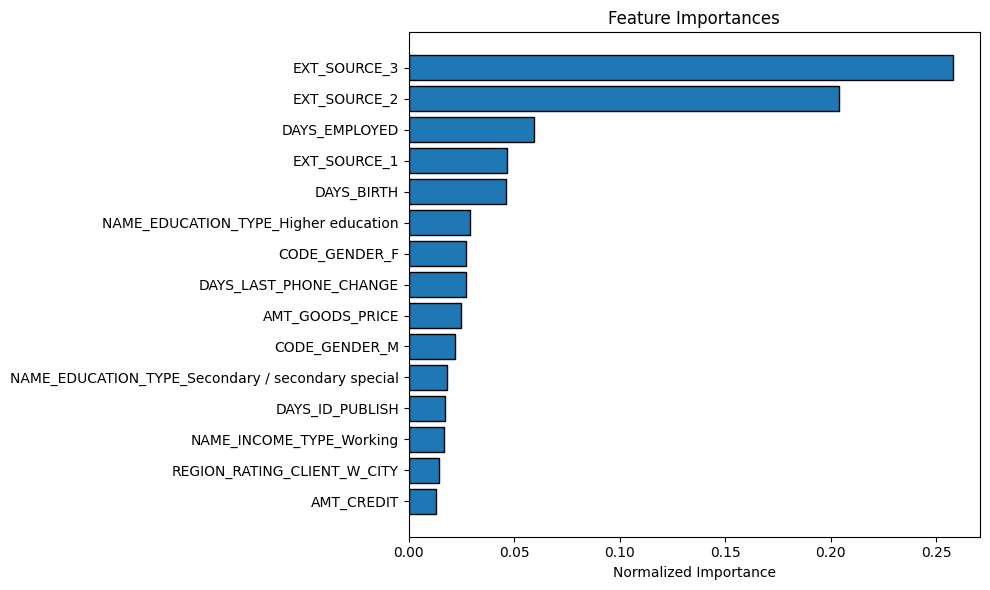

In [16]:
plot_feature_importances(features, random_forest.feature_importances_)

In [17]:
from vectice import Model

random_forest = Model(name="Probability of default", 
                      predictor=random_forest, 
                      properties = random_forest.get_params(), 
                      metrics = metric, 
                      attachments=['Feature Importances.png', "Prediction_distribution.png", "Percentage of Defaults by Quantile.png", "roc_curve.png"],
                      derived_from=modeling_ds,
                      technique="Random Forest")
iteration.log(random_forest)

New model: 'Probability of default' version: 'Version 1' added to iteration: 1.
Attachments: roc_curve.png, Percentage of Defaults by Quantile.png, Prediction_distribution.png, Feature Importances.png
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739



# Feature Engineering

## Create some domain features

In [18]:

app_train_feat['CREDIT_INCOME_PERCENT'] = app_train_feat['AMT_CREDIT'] / app_train_feat['AMT_INCOME_TOTAL']
app_train_feat['ANNUITY_INCOME_PERCENT'] = app_train_feat['AMT_ANNUITY'] / app_train_feat['AMT_INCOME_TOTAL']
app_train_feat['CREDIT_TERM'] = app_train_feat['AMT_ANNUITY'] / app_train_feat['AMT_CREDIT']
app_train_feat['DAYS_EMPLOYED_PERCENT'] = app_train_feat['DAYS_EMPLOYED'] / app_train_feat['DAYS_BIRTH']
app_train_feat['NEW_SOURCES_PROD'] = app_train_feat['EXT_SOURCE_1'] * app_train_feat['EXT_SOURCE_2'] * app_train_feat['EXT_SOURCE_3']
app_train_feat['NEW_EXT_SOURCES_MEAN'] = app_train_feat[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

In [19]:
app_test_feat['CREDIT_INCOME_PERCENT'] = app_test_feat['AMT_CREDIT'] / app_test_feat['AMT_INCOME_TOTAL']
app_test_feat['ANNUITY_INCOME_PERCENT'] = app_test_feat['AMT_ANNUITY'] / app_test_feat['AMT_INCOME_TOTAL']
app_test_feat['CREDIT_TERM'] = app_test_feat['AMT_ANNUITY'] / app_test_feat['AMT_CREDIT']
app_test_feat['DAYS_EMPLOYED_PERCENT'] = app_test_feat['DAYS_EMPLOYED'] / app_test_feat['DAYS_BIRTH']
app_test_feat['NEW_SOURCES_PROD'] = app_test_feat['EXT_SOURCE_1'] * app_test_feat['EXT_SOURCE_2'] * app_test_feat['EXT_SOURCE_3']
app_test_feat['NEW_EXT_SOURCES_MEAN'] = app_test_feat[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

In [20]:
app_train_feat.to_csv("./application_feat.csv",index=False)
clean_ds = Dataset.clean(name = "Application train w feature", 
                         resource = FileResource(paths='./application_feat.csv', dataframes=app_train_feat), 
                         attachments=["Correlation.png","Target distribution.png","Failure to repay by age group.png" ], 
                         derived_from=data_origin)

iteration.log(clean_ds)

File: ./application_feat.csv wrapped successfully.
Statistics are only captured for the first 100 columns of your dataframe.
New dataset: 'Application train w feature' version: 'Version 1' added to iteration: 1.
Attachments: Failure to repay by age group.png, Target distribution.png, Correlation.png
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739



## Random Forest


In [21]:
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train_feat:
    train_no_missing = app_train_feat.drop(columns = ['TARGET'])

features = list(train_no_missing.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')
# Fit on the training data
imputer.fit(train_no_missing)

# Transform both training and testing data
train_no_missing = pd.DataFrame(imputer.transform(train_no_missing), columns=features).set_index('SK_ID_CURR')
test_no_missing = pd.DataFrame(imputer.transform(app_test_feat), columns=features).set_index('SK_ID_CURR')



In [22]:
train_no_missing.to_csv("./training.csv",index=False)
test_no_missing.to_csv("./testing.csv",index=False)

modeling_ds = Dataset.modeling(name = "Modeling with domain features",training_resource = FileResource(paths='./training.csv', dataframes=train_no_missing), 
                            testing_resource=FileResource(paths='./testing.csv', dataframes=test_no_missing), 
                            derived_from=clean_ds)

iteration.log(modeling_ds)

File: ./training.csv wrapped successfully.
File: ./testing.csv wrapped successfully.
Statistics are only captured for the first 100 columns of your dataframe.
Statistics are only captured for the first 100 columns of your dataframe.
New dataset: 'Modeling with domain features' version: 'Version 1' added to iteration: 1.
Attachments: None
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739



ROC AUC Score: 0.737135773824035
F1 Score: 0.27555905305265915
Recall Score: 0.5652407855797686


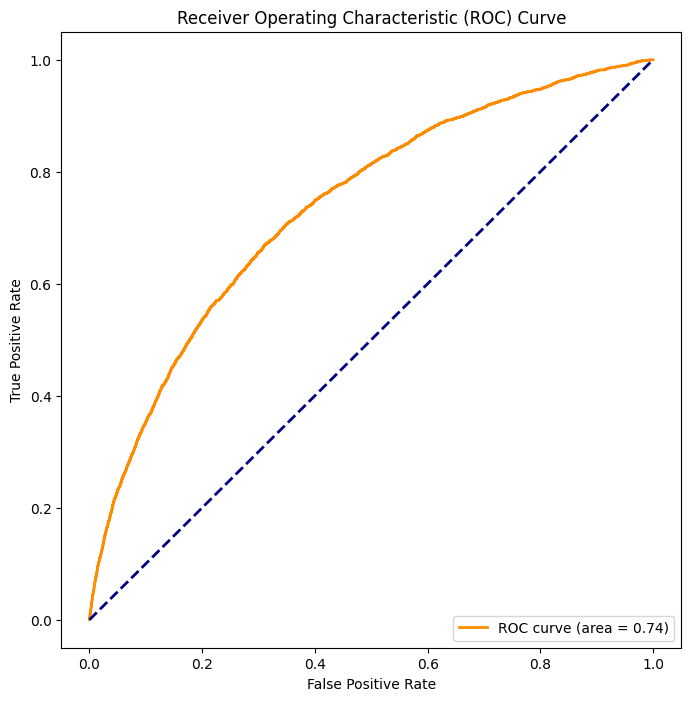

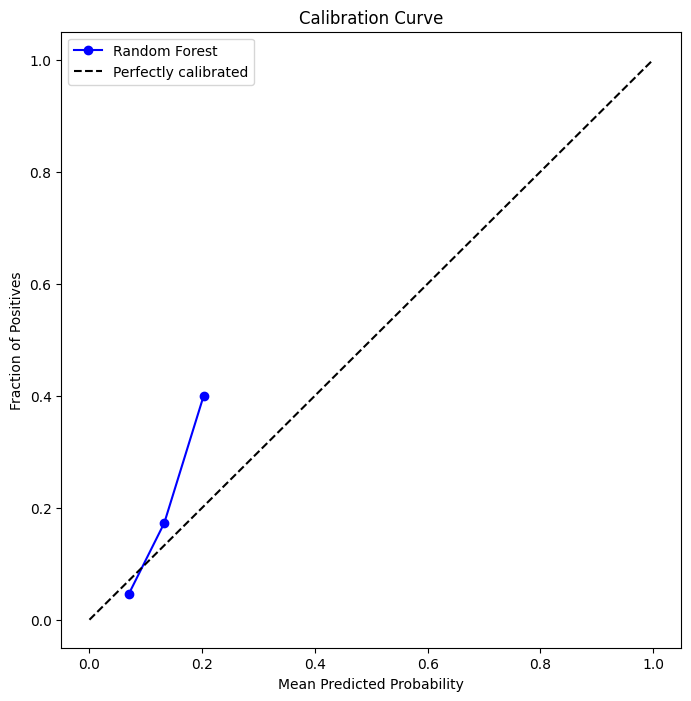

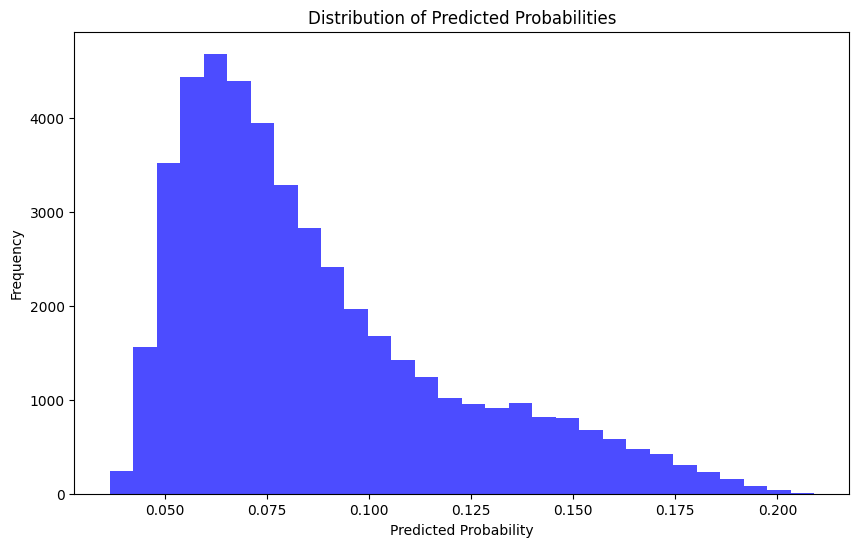

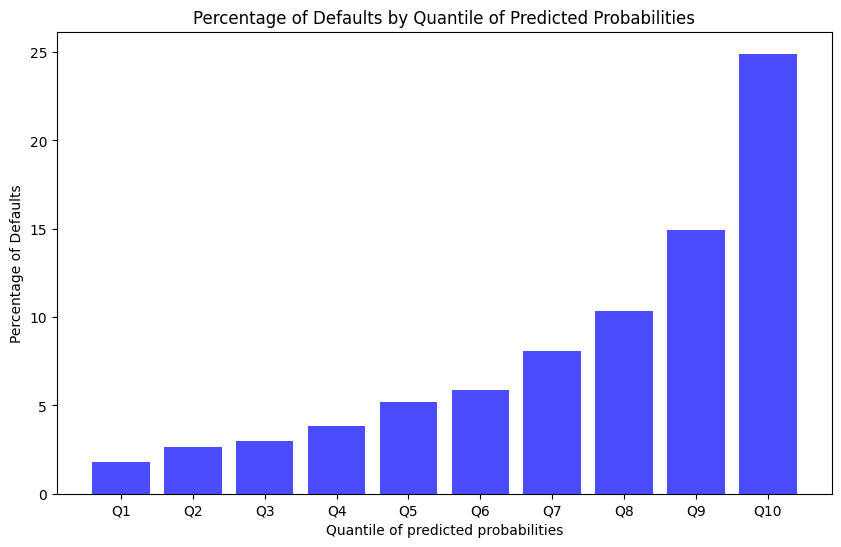

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 150, random_state = 50, min_samples_leaf=0.015, n_jobs = -1)
features = list(train_no_missing.columns)
# Train on the training data
random_forest.fit(train_no_missing, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_

# Make predictions on the test data
predictions = random_forest.predict_proba(test_no_missing)[:, 1]

roc_auc = roc_auc_score(app_test_feat_target.values, predictions)
# Sort instances based on predicted probabilities
sorted_indices = np.argsort(predictions)[::-1]
sorted_labels = app_test_feat_target.iloc[sorted_indices]

# Define the desired percentage (e.g., 25%)
desired_percentage = 0.25

# Identify the threshold probability corresponding to the desired percentage
threshold_index = int(desired_percentage * len(predictions))
threshold_probability = predictions[sorted_indices[threshold_index]]

# Apply the threshold to classify instances
binary_predictions = (predictions >= threshold_probability).astype(int)

# Calculate the recall at the desired percentage
recall = recall_score(app_test_feat_target.values, binary_predictions)
f1 = f1_score(app_test_feat_target.values,binary_predictions)

metric = {"auc": float(roc_auc),
          f"recall at {desired_percentage}%": float(recall),
          f"f1_score at {desired_percentage}%":float(f1)}

print("ROC AUC Score:", roc_auc)
print("F1 Score:", f1)
print("Recall Score:", recall)


# Plot ROC curve
fpr, tpr, thresholds = roc_curve(app_test_feat_target.values, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

# Plot calibration curve
prob_true, prob_pred = calibration_curve(app_test_feat_target.values, predictions, n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="upper left")
plt.savefig("calibration.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.savefig("Prediction_distribution.png")
plt.ylabel('Frequency')
plt.show()

# Create a DataFrame with predicted probabilities and true labels
df_results = pd.DataFrame({'Probability': predictions, 'Default': app_test_feat_target.values})

# Sort instances based on predicted probabilities
df_results = df_results.sort_values(by='Probability', ascending=False)

# Divide the sorted instances into quantiles (e.g., deciles)
num_quantiles = 10
df_results['Quantile'] = pd.qcut(df_results['Probability'], q=num_quantiles, labels=False, duplicates='drop')

# Calculate the percentage of defaults in each quantile
quantile_defaults = df_results.groupby('Quantile')['Default'].mean() * 100

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(quantile_defaults.index, quantile_defaults.values, color='blue', alpha=0.7)
plt.xlabel('Quantile of predicted probabilities')
plt.ylabel('Percentage of Defaults')
plt.title('Percentage of Defaults by Quantile of Predicted Probabilities')
plt.xticks(ticks=quantile_defaults.index, labels=[f'Q{i + 1}' for i in quantile_defaults.index])
plt.savefig("Percentage of Defaults by Quantile.png")
plt.show()

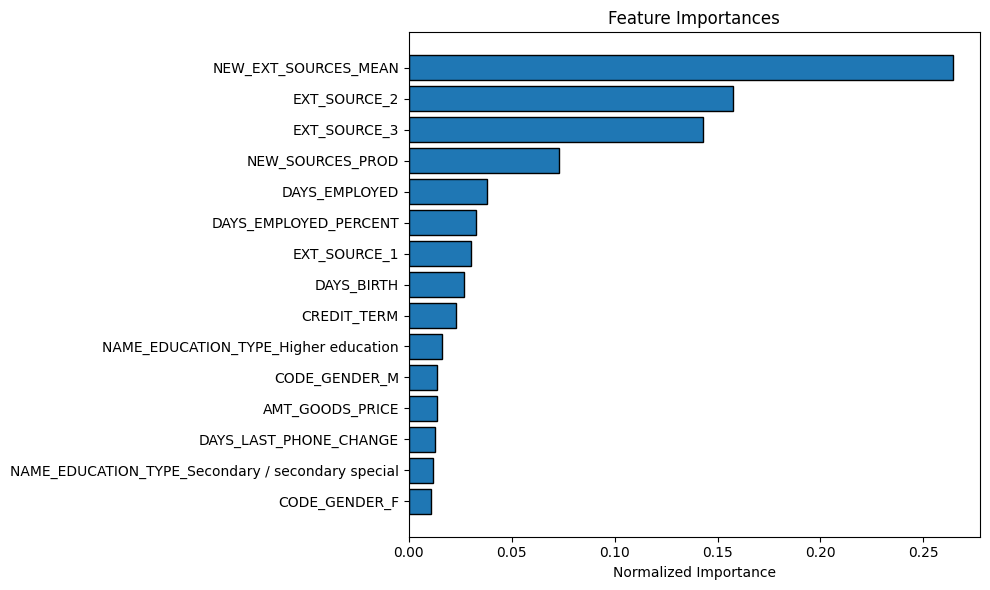

In [24]:
plot_feature_importances(features, random_forest.feature_importances_)

In [25]:
from vectice import Model
random_forest = Model(name="Probability of default", 
                      predictor=random_forest, 
                      properties = random_forest.get_params(), 
                      metrics = metric, 
                      attachments=['Feature Importances.png', "Prediction_distribution.png", "Percentage of Defaults by Quantile.png", "roc_curve.png"],
                      derived_from=modeling_ds,
                      technique="Random Forest")


iteration.log(random_forest)

New version: 'Version 2' of model: 'Probability of default' added to iteration: 1.
Attachments: roc_curve.png, Percentage of Defaults by Quantile.png, Prediction_distribution.png, Feature Importances.png
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739



# LightGBM

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 21108, number of negative: 240276
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.900913
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.508087
[LightGBM] [Debug] init for col-wise cost 0.039171 seconds, init for row-wise cost 0.052501 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info]

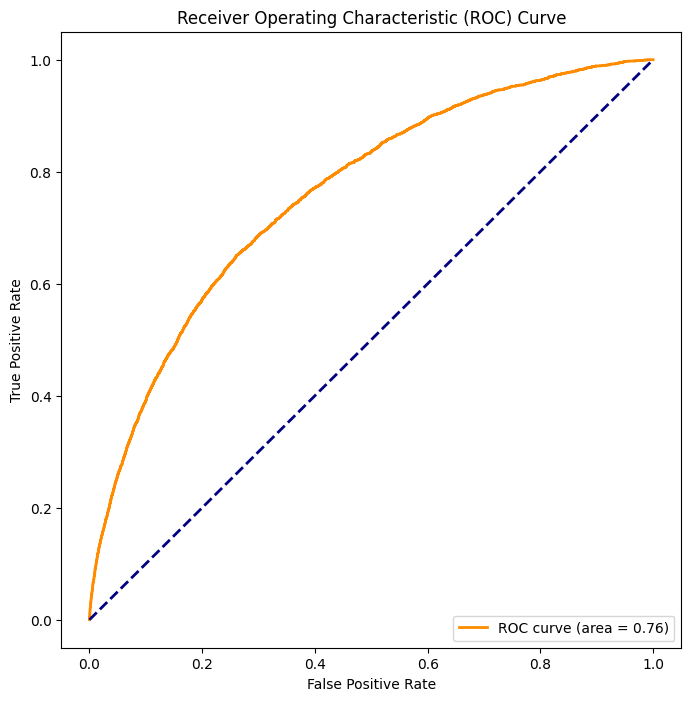

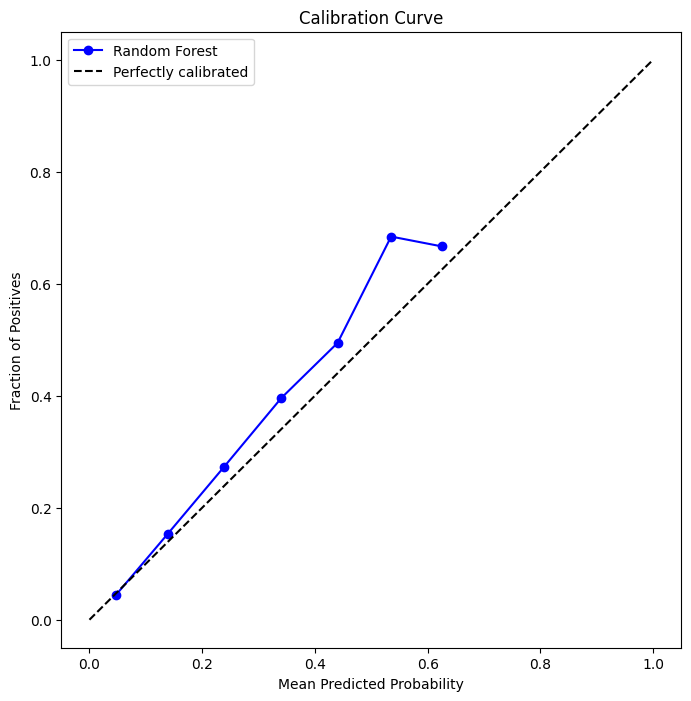

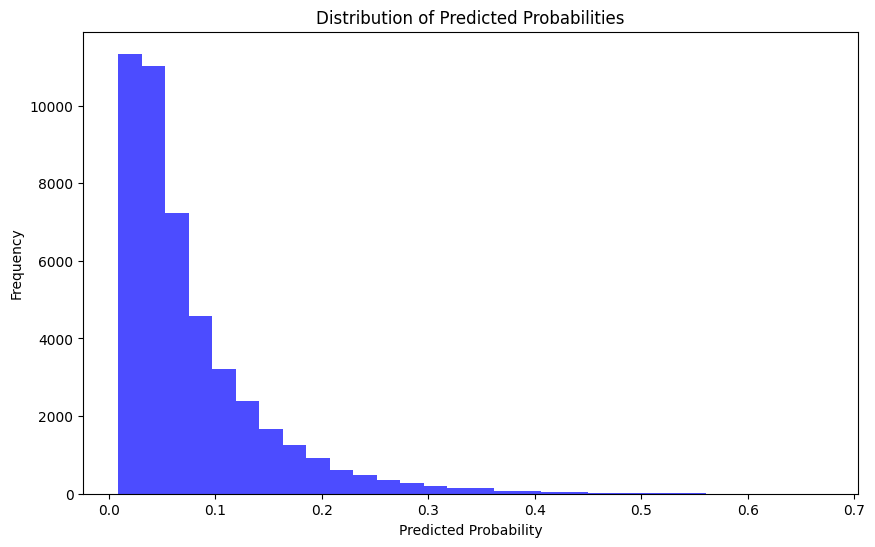

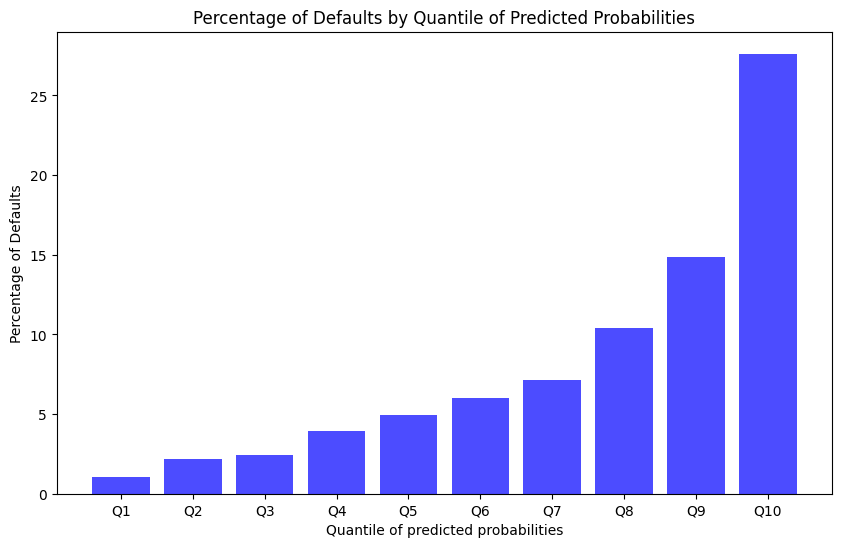

In [26]:
import lightgbm as lgb


# Set hyperparameters for LightGBM
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model using scikit-learn API
lgb_model = lgb.LGBMClassifier(**params, n_estimators=1000, early_stopping_rounds=10, verbose=10)
lgb_model.fit(train_no_missing.values, train_labels.values, eval_set=[(test_no_missing.values, app_test_feat_target)], eval_metric='auc')

# Extract feature importances
feature_importance_values = lgb_model.feature_importances_

# Make predictions on the test data
predictions = lgb_model.predict_proba(test_no_missing)[:, 1]

# Calculate AUC score
roc_auc = roc_auc_score(app_test_feat_target.values, predictions)
# Sort instances based on predicted probabilities
sorted_indices = np.argsort(predictions)[::-1]
sorted_labels = app_test_feat_target.iloc[sorted_indices]

# Define the desired percentage (e.g., 25%)
desired_percentage = 0.25

# Identify the threshold probability corresponding to the desired percentage
threshold_index = int(desired_percentage * len(predictions))
threshold_probability = predictions[sorted_indices[threshold_index]]

# Apply the threshold to classify instances
binary_predictions = (predictions >= threshold_probability).astype(int)

# Calculate the recall at the desired percentage
recall = recall_score(app_test_feat_target.values, binary_predictions)
f1 = f1_score(app_test_feat_target.values,binary_predictions)


metric = {"auc": float(roc_auc),
          f"recall at {desired_percentage}%": float(recall),
          f"f1_score at {desired_percentage}%":float(f1)}

print("ROC AUC Score:", roc_auc)
print("F1 Score:", f1)
print("Recall Score:", recall)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(app_test_feat_target.values, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

# Plot calibration curve
prob_true, prob_pred = calibration_curve(app_test_feat_target.values, predictions, n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="upper left")
plt.savefig("calibration.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.savefig("Prediction_distribution.png")
plt.ylabel('Frequency')
plt.show()

# Create a DataFrame with predicted probabilities and true labels
df_results = pd.DataFrame({'Probability': predictions, 'Default': app_test_feat_target.values})

# Sort instances based on predicted probabilities
df_results = df_results.sort_values(by='Probability', ascending=False)

# Divide the sorted instances into quantiles (e.g., deciles)
num_quantiles = 10
df_results['Quantile'] = pd.qcut(df_results['Probability'], q=num_quantiles, labels=False, duplicates='drop')

# Calculate the percentage of defaults in each quantile
quantile_defaults = df_results.groupby('Quantile')['Default'].mean() * 100

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(quantile_defaults.index, quantile_defaults.values, color='blue', alpha=0.7)
plt.xlabel('Quantile of predicted probabilities')
plt.ylabel('Percentage of Defaults')
plt.title('Percentage of Defaults by Quantile of Predicted Probabilities')
plt.xticks(ticks=quantile_defaults.index, labels=[f'Q{i + 1}' for i in quantile_defaults.index])
plt.savefig("Percentage of Defaults by Quantile.png")
plt.show()



In [27]:
from vectice import Model
lgb = Model(name="Probability of default", 
                      predictor=lgb_model, properties = lgb_model.get_params(),
                      metrics = metric, 
                      attachments=['Feature Importances.png', "Prediction_distribution.png", "Percentage of Defaults by Quantile.png", "roc_curve.png"],
                      derived_from=modeling_ds,
                      technique="Light GBM")

iteration.log(lgb)

New version: 'Version 3' of model: 'Probability of default' added to iteration: 1.
Attachments: roc_curve.png, Percentage of Defaults by Quantile.png, Prediction_distribution.png, Feature Importances.png
Link to iteration: https://app.vectice.com/browse/iteration/ITR-1739

